## Python statistics essential training - 05_04_crossvalidation

Previous lesson used classical analytics heavy techniques to eval goodness of fit (of model to the data) and to compare models based on their explanatory power & simplicity

CROSS-VALIDATION: Simpler strategy to compare models

Split data into training-set & testing-set

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading gapminder data for year 1985 (Live Aid!).

In [6]:
gapminder = pd.read_csv('gapminder.csv')

In [7]:
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [8]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    pp.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Model formulas from the last two videos

In [9]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')

To Divide the data, first need to shuffle it (to avoid possible groupings that could affect models)

In [11]:
# Shuffle using pandas .sample() method
shuffled = gdata.sample(len(gdata))
# resulting dataset should have all the same data as the original, records are now just shuffled

In [12]:
# Use pandas .iloc[] to divide the dataset into two
# Use double slash (//) to do division
# Note: could just assign the variables in two lines, this one-line is equivalent
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:]

In [13]:
# Fit the model to the training data
surviving = smf.ols(f_surviving, data=training).fit()

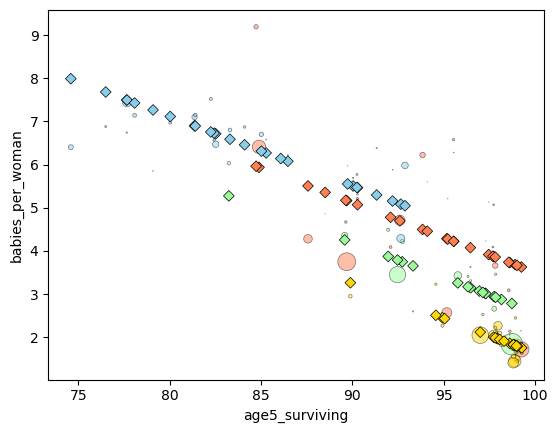

In [14]:
plotfit(surviving,training)

In [15]:
surviving.mse_resid

0.8310298100480255

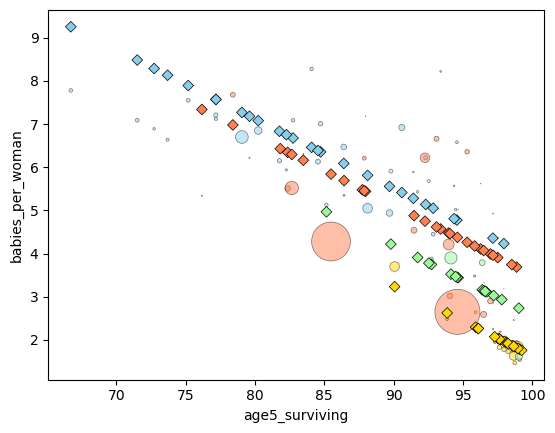

In [16]:
# Try the model on the testing data
plotfit(surviving,testing)

See that the data points are different but the fit looks comparble

In [17]:
# To compute the Mean Squared Error (need to do some work since an object not created so can't use the method

#Compute the residuals (.predict() method), and substract the observed data
resid = surviving.predict(testing) - testing.babies_per_woman
# Compute the degrees of freedom (length of the data minus the number of parameters in the model (-1 b/c the number of params doesn't count the constant, but we should)
df = len(testing) - surviving.df_model - 1
# Square the residuals, sum them, then divide by the df
np.sum(resid**2) / df

1.1566487040577484

In [19]:
# Create a func of computing the MSE
# repeats the shuffling and fitting a few times to account for variation because of the shuffling
def cross_validate(data,model_formula,response_variable,n=100):
    ret = []
    
    for i in range(n):
        #shuffle the data
        shuffled = data.sample(len(data))
        
        #divide the data in half
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        # Train the model on the training set
        trained = smf.ols(model_formula, data=training).fit()
        
        # Compute the MSE
        resid = trained.predict(testing) - testing[response_variable]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
        
        # Make a list of the MSE's returned
        ret.append(mse)
    
    # Find the avg of the list of MSE of the repeated fittings
    return np.mean(ret)

In [20]:
cross_validate(gdata,f_groupmeans,'babies_per_woman')

1.63647093087047

In [21]:
cross_validate(gdata,f_surviving,'babies_per_woman')

1.034821924259105

In [22]:
cross_validate(gdata,f_srp,'babies_per_woman')

1.1507307580845931